# GSOC Compation 2024 - Test 1 for the Human AI

## Ioanna Poulou

### Importing the necessary libraries

In [1]:
%env HSA_OVERRIDE_GFX_VERSION=10.3.0

import random
import re
from math import ceil
import os
import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s.%(msecs)03d ==%(levelname)s== %(message)s',
    datefmt='%H:%M:%S',
)
    
import numpy as np

import pandas as pd

from pdf2image import convert_from_path

import matplotlib.pyplot as plt



import torch.nn.functional as F
import torch
import torch.nn as nn 
from torch.utils.data import DataLoader
from torchvision import transforms
from torchaudio.models.decoder import CTCDecoder, ctc_decoder

from PIL import Image, ImageOps

from tqdm.notebook import trange, tqdm_notebook

#install the poppler
# !apt-get install poppler-utils -y 

env: HSA_OVERRIDE_GFX_VERSION=10.3.0


### Some basic configurations

In [2]:
WORKING_DIR="/root/gsoc/"
SPECIFIC_DATASET = WORKING_DIR + "data/specific/"
GENERAL_DATASET = WORKING_DIR + "data/general/"

TRAIN = True

IMAGES_START = 1 
IMAGES_END = -6 

MAX_TEXT_LEN = 4500
BLANK_SYMBOL = 0

### Seed all the random number generators for reproducibility


In [3]:
def set_seed(seed = 1234):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# set seed
set_seed()

### Use the GPU if available

In [4]:
#choose device to train the model
compute_unit = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.info(f"Compute unit: {compute_unit}")

17:15:36.143 ==INFO== Compute unit: cuda


### Store all the images in an array

In [5]:
# Store Pdf with convert_from_path function
images_specific = convert_from_path(SPECIFIC_DATASET + 'Padilla - Nobleza virtuosa_testExtract.pdf')

for index,image in enumerate(images_specific):
    images_specific[index] = Image.fromarray(np.asarray(image))
        
images_general = []

files = os.listdir(GENERAL_DATASET + "images/")
files.sort()

for file in files:
    if file.endswith(".tiff"):
        images_general.append(Image.fromarray(np.asarray(Image.open(GENERAL_DATASET + "images/" + file))))
        

### Basic text to integer conversion mapping Class

In [33]:
class TextTransform:
    def __init__(self):
        self.char_to_int = {"BLANK": 0}
        self.int_to_char = {0: ""}
        self.entries = 1   # 0 is reserved for blank symbol, 1 is reserved for end symbol
        self.max_len = 0
        self.vocab = ""
        
    # fit the encoder to the text
    def fit_text(self, text):
        for char in text:
            vocab_entry = char
            
            if char == ' ':
                char = "SPACE"
                
            if char == '\n':
                char = "NEWLINE"
            
            if char not in list(self.char_to_int.keys()):
                self.char_to_int[char] = self.entries
                self.int_to_char[self.entries] = char
                self.entries += 1
                self.vocab += vocab_entry
                
        return self.text_to_int(text)
    
    # pad the text to the maximum length     
    def pad_array(self, array, max_len = None):
        
        pad_len = max_len if max_len is not None else self.max_len
        original_len = len(array) - 1 # -1 because the last element is the end symbol
        
        while len(array) < pad_len:
            array.append(BLANK_SYMBOL)
            
        return array, original_len
        
    
    # transform the text to numerical values
    def text_to_int(self, text):
        ret = []
        
        for char in text:
            if char == ' ':
                char = "SPACE"
                
            if char == '\n':
                char = "NEWLINE"
                
            char_ret = self.char_to_int.get(char, None)
            if char_ret is None:
                raise Exception(f"Character {char} (ascii: {ord(char)}) not found in vocabulary")
                
            ret.append(char_ret)
                        
        self.max_len = max(self.max_len, len(ret))    
        
        return ret
    
    # transform the numerical values to text
    def int_to_text(self, arr):
        ret = ""
        
        for i in range(len(arr)):   
            try:
                char = self.int_to_char[arr[i]]
            except:
                # raise Exception(f"Character with index {arr[i]} not found in vocabulary max index: {self.entries}")
                continue
            
            if char == "SPACE":
                char = " "
                
            if char == "NEWLINE":
                char = "\n"
                
            ret += char
            
        return ret
    
    def find_max_len(self):
        return self.max_len
    
    def find_vocabulary_size(self):
        return self.entries
    
    def find_vocabulary(self):
        return list(self.vocab)

## We encode the Ground Truth labels into integers

In [34]:
english_alphabet = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
spanish_special = "ñÑ"
numbers = "0123456789"
punctuation = ".,;:!?¿¡"
special = "\n \'\"-_()<>|-"
alphabet = english_alphabet + spanish_special + numbers + punctuation + special
toned_dict = {"á":"a", "à":"a", "é":"e", "è":"e", "ë":"e", "í":"i", "ó":"o", "ö":"o", "ú":"u", "Á":"A", "É":"E", "Í":"I", "Ó":"O", "Ú":"U", "ü":"u", "Ü":"U"}
Circumflexed_dict = {"â":"an", "ê":"en", "î":"in", "ô":"on", "û":"un", "Â":"An", "Ê":"En", "Î":"In", "Ô":"On", "Û":"Un"}

y_dataset_general = pd.read_csv(GENERAL_DATASET +'ydataset.csv') 
y_dataset_specific = pd.read_csv(SPECIFIC_DATASET +'ydataset.csv')
y_text_general = y_dataset_general[["Text"]].copy()

def remove_tones(text):
    global toned_dict
    for key in list(toned_dict.keys()):
        text = text.replace(key, toned_dict[key])
    
    return text

def remove_circumflexed(text):
    ret = ""
    
    for char in text:
        if char in list(Circumflexed_dict.keys()):
            ret += Circumflexed_dict[char]
        else:
            ret += char
        
    return ret

def remove_unwanted(text):
    ret = ""
    
    for char in text:
        if char in alphabet:
            ret += char

    return ret


text_transform = TextTransform()
# fit the dictionary to the text
text_transform.fit_text(alphabet)

# Preprocess general
y_text_general["Text"] = y_text_general["Text"].apply(lambda x: remove_tones(x))
y_text_general["Text"] = y_text_general["Text"].apply(lambda x: remove_circumflexed(x))
y_text_general["Text"] = y_text_general["Text"].apply(lambda x: remove_unwanted(x))

# convert Y to numerical values
y_text_general["Text"] = y_text_general["Text"].apply(lambda x: text_transform.text_to_int(list(x)))
# Pad the text to the maximum length
y_set_general = y_text_general["Text"].tolist()
y_lengths_general = []

for i in range(len(y_set_general)):
    y_set_general[i], original_len = text_transform.pad_array(y_set_general[i], MAX_TEXT_LEN)
    y_lengths_general.append(original_len)

# Finally we can convert the dataframe to a numpy array
y_set_general = np.array(y_set_general)
y_lengths_general = np.array(y_lengths_general)


# Preprocess specific
y_text_specific = y_dataset_specific[["Text"]].copy()
y_text_specific["Text"] = y_text_specific["Text"].apply(lambda x: remove_tones(x))
y_text_specific["Text"] = y_text_specific["Text"].apply(lambda x: remove_circumflexed(x))
y_text_specific["Text"] = y_text_specific["Text"].apply(lambda x: remove_unwanted(x))

# convert Y to numerical values
y_text_specific["Text"] = y_text_specific["Text"].apply(lambda x: text_transform.text_to_int(list(x)))
# Pad the text to the maximum length
y_set_specific = y_text_specific["Text"].tolist()
y_lengths_specific = []

for i in range(len(y_set_specific)):
    y_set_specific[i], original_len = text_transform.pad_array(y_set_specific[i], MAX_TEXT_LEN)
    y_lengths_specific.append(original_len)
    
# Finally we can convert the dataframe to a numpy array
y_set_specific = np.array(y_set_specific)
y_lengths_specific = np.array(y_lengths_specific)

# PreProcess the images

In [8]:
def resize_images(images: list, height, width):
    resized_images = []
    
    for image in images:
        resized_images.append(image.resize((width, height)))
        
    return resized_images
    

def crop_images(images : list):
    cropped_images = []
    
    # Define a size to resize the images
    
    for image in images:
        width, height = image.size
        
        # Crop the image in half and take the first half
        cropped_img = image.crop((220, 0, width // 2, height))

        cropped_images.append(cropped_img)  

        # Crop the image to take the second half
        cropped_img = image.crop((width // 2 + 1, 0, width - 210, height))

        cropped_images.append(cropped_img)
        
    return cropped_images
    
    
def normalization(images):
    images = images / 255.0
    
    images = images.astype('float32')
    
    return images
        
def grey_convertion(images):
    grey_images = []
    for image in images:
        grey_images.append(ImageOps.grayscale(image))
        
    return grey_images
    
        
# image cropping
images_specific = crop_images(images_specific)
logging.info(f"Images cropped")
    
# image resizing
images_specific = resize_images(images_specific, 1220, 1220)
logging.info(f"Images resized")

# grey convertion
images_specific = grey_convertion(images_specific)
logging.info(f"Images converted to grey")

images_specific = np.asarray(images_specific)

# normalize the images
images_specific = normalization(images_specific)
logging.info(f"Images normalized")


# image cropping
images_general = resize_images(images_general, 1220, 1220)
logging.info(f"Images resized")

# grey convertion
images_general = grey_convertion(images_general)
logging.info(f"Images converted to grey")

images_general = np.asarray(images_general)

# normalize the images
images_general = normalization(images_general)
logging.info(f"Images normalized")


17:15:45.680 ==INFO== Images cropped


17:15:46.611 ==INFO== Images resized
17:15:46.650 ==INFO== Images converted to grey
17:15:46.783 ==INFO== Images normalized
17:16:04.407 ==INFO== Images resized
17:16:04.989 ==INFO== Images converted to grey
17:16:06.131 ==INFO== Images normalized


## Move our data to tensors

In [9]:
# Convert each image to a PyTorch tensor
Images_Tensor_general = torch.stack([transforms.ToTensor()(x) for x in images_general])

Images_Tensor_specific = torch.stack([transforms.ToTensor()(x) for x in images_specific])
# For the images we must remove the first and the 6 last as they are part of the test set
Images_Tensor_specific = Images_Tensor_specific[IMAGES_START:IMAGES_END]

# Create a tensor with the new_Y
Transcripts_Tensor_General = torch.tensor(y_set_general, dtype=torch.float)
Lengths_Tensor_General = torch.tensor(y_lengths_general, dtype=torch.long)

Transcripts_Tensor_Specific = torch.tensor(y_set_specific, dtype=torch.float)
Lengths_Tensor_Specific = torch.tensor(y_lengths_specific, dtype=torch.long)

# Define the Neural Network

In [10]:

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, conv_kernel_size, padding=0):
        super(BasicBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=conv_kernel_size,padding=padding,bias=False)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.bn(x)
        
        return x


class CNN(nn.Module):
    def __init__(self, conv_cfg,):
        super(CNN, self).__init__()
        self.kernel_size = 3
        pad = 1

        # A first layer to reduce the size of the image
        self.layers = nn.ModuleList([nn.Conv2d(in_channels=1,out_channels=32,kernel_size=7,stride=2,padding=3), nn.ReLU()]) 
        channels_in = 32
        
        for index, layer in enumerate(conv_cfg):            
            if layer == "M":
                # Reduce the size of the image
                self.layers.add_module(f"MaxPool_{index}", nn.MaxPool2d(kernel_size=2,stride=2))
            else:
                num_of_layers, channels_out = layer
                for i in range(num_of_layers):
                    self.layers.add_module(f"Conv_{index}_{i}", BasicBlock(channels_in, channels_out, self.kernel_size, padding=pad))
                    channels_in = channels_out
            
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        
        return x


class RNN(nn.Module):
    def __init__(self, cfg, output_classes, input_size, dropout = 0.2):
        super(RNN, self).__init__()

        self.hidden_size = cfg[0]
        self.num_layers = cfg[1]

        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=self.hidden_size,
            batch_first=True,
            dropout=dropout,
            num_layers=self.num_layers,
            bidirectional = True,
        )
        self.dp = nn.Dropout(dropout)
        self.linear = nn.Linear(self.hidden_size * 2, output_classes)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.dp(x)
        x = self.linear(x)
        return x
    
    
class CRNN(nn.Module):
    def __init__(self,cnn_cfg, rnn_cfg, input_height, input_width, output_classes, output_max_len, dropout = 0.2):
        super(CRNN,self).__init__()
        
        self.CNN_net = CNN(cnn_cfg)
        
        max_pool_layers = 1 # Consider the first reduction
        for layer in cnn_cfg:
            if layer == "M":
                max_pool_layers += 1

        cnn_height = int(input_height / (2 ** max_pool_layers))
        cnn_width = int(input_width / (2 ** max_pool_layers))
        
        final_channels = cnn_cfg[-1][-1]
        
        self.linear2 = nn.Linear(final_channels * cnn_height, output_max_len)
        
        
        self.RNN_net = RNN(rnn_cfg, output_classes, cnn_width, dropout)

        
    def forward(self, x: torch.Tensor):        
        x = self.CNN_net(x)
                
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])
        
        x.transpose_(1, 2)
        x = self.linear2(x)
        x.transpose_(1, 2)
        
        x = self.RNN_net(x)
        
        return x

# Helper Functions

In [11]:
def plot_learning_curves(list_of_train_losses, list_of_valid_losses, list_of_f1_scores_train, list_of_f1_scores_valid, epoch_size_list):   
    plt.plot(epoch_size_list, list_of_f1_scores_train)
    plt.plot(epoch_size_list, list_of_f1_scores_valid)
    plt.xlabel("Epochs")
    plt.ylabel("F1 scores",fontweight='bold')
    plt.ylim(ymin=0.0, ymax=1.0)
    plt.legend(["Train", "Valid"])
    plt.show()

    # plot validation and training loss
    plt.plot(epoch_size_list, list_of_train_losses)
    plt.plot(epoch_size_list, list_of_valid_losses)
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.legend(["Train", "Valid"])
    plt.show()

# Model Training

In [12]:

def model_train(
    TrainDataLoader: DataLoader, 
    ValDataloader : DataLoader,
    neural_network_model: nn.Module,
    loss_func, 
    optimizer, 
    scheduler,
    epochs = 10,
    compute_unit = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    ShowProgBar = True,
    VerboseProgressBars = True,
    ProgBarText: str = "Training on %d",
):
    
    ProgBarText = re.sub(r"%d", str(compute_unit), ProgBarText)
    
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    
    
    for epoch in trange(epochs, desc=ProgBarText, unit="epoch", disable= not ShowProgBar):
        neural_network_model.train()

        accuracies = []
        losses = []
        CERs = []

        # Training phase
        for batch in tqdm_notebook(TrainDataLoader, desc=f"Epoch {epoch+1}/{epochs} Training", unit="batch" , disable=not VerboseProgressBars):
            batch = [x.to(compute_unit) for x in batch]
            
            Xtrain , Ytrain, Ylens = batch
            optimizer.zero_grad() # Zero the gradients
            
            # Perform the forward pass
            YpredLikly = neural_network_model(Xtrain).cpu()
            
            # Transform the YpredLikly to Ypred and YpredProb
            Ypred = torch.argmax(YpredLikly, dim=2)
            YpredProb = F.log_softmax(YpredLikly, dim=2)
            
            
            # Calculate the loss
            input_lengths = torch.full(size=(YpredLikly.shape[0],), fill_value=MAX_TEXT_LEN, dtype=torch.long, device=torch.device("cpu"))  
            
            YpredProb = YpredProb.permute(1, 0, 2)          # (N, T, C) -> (T, N, C)
                        
            TrainLoss = loss_func(YpredProb, Ytrain.cpu(), input_lengths, Ylens.cpu())
            TrainLoss.backward() # Perform the backward pass
           
            optimizer.step()
            scheduler.step()

            # Calculate and store metrics
            losses.append(TrainLoss.item())
            for i in range(Xtrain.shape[0]):
                accuracy = (Ypred[i][:Ylens[i]].cpu() == Ytrain[i][:Ylens[i]].cpu()).sum().item() / Ylens[i].item()
                accuracies.append(accuracy)
                # CER = decoder.cer(Ypred[i].unsqueeze(0), Ytrain[i].unsqueeze(0))
                # CERs.append(CER)
            
            del Xtrain, Ytrain, YpredProb
            
        print(f"Epoch {epoch+1}/{epochs} Training: Accuracy: {np.mean(accuracies):.4f}, Loss: {np.mean(losses):.4f}")
        train_acc.append(np.mean(accuracies))
        train_loss.append(np.mean(losses))
        
        accuracies = []
        losses = []

        # Validation phase
        with torch.no_grad():
            
            neural_network_model.eval()
            
            for batch in ValDataloader:
                
                batch = [x.to(compute_unit) for x in batch]
                Xval , Yval, Ylens = batch
                
                # predict each XvalBatch              
                YvalLikly = neural_network_model(Xval)
                
                # Transform the YpredLikly to Ypred and YpredProb
                Ypred = torch.argmax(YvalLikly, dim=2)
                YpredProb = F.log_softmax(YvalLikly, dim=2).cpu()
                
                input_lengths = torch.full(size=(YvalLikly.shape[0],), fill_value=MAX_TEXT_LEN, dtype=torch.long, device=torch.device("cpu"))  
            
                YpredProb = YpredProb.permute(1, 0, 2)          # (N, T, C) -> (T, N, C)
                ValLoss = loss_func(YpredProb, Yval.cpu(), input_lengths, Ylens.cpu())
                
                losses.append(ValLoss.item())
                
                for i in range(Xval.shape[0]):
                    accuracy = (Ypred[i][:Ylens[i]].cpu() == Yval[i][:Ylens[i]].cpu()).sum().item() / Ylens[i].item()
                    accuracies.append(accuracy)
                
        print(f"Epoch {epoch+1}/{epochs} Validation: Accuracy: {np.mean(accuracies):.4f}, Loss: {np.mean(losses):.4f}")
        val_acc.append(np.mean(accuracies))
        val_loss.append(np.mean(losses))
        
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Val Accuracy")

    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()


    return neural_network_model

## Create the dataloaders for training and validation

In [13]:
# Some dataloader parameters

BatchSize = 8
Shuffle = True

In [14]:
# We will split the data with a 80/20 ratio
train_size_general = int(0.8 * len(Images_Tensor_general))
val_size_general = len(Images_Tensor_general) - train_size_general

# Split the data
train_images_general = Images_Tensor_general[:train_size_general]
val_images_general = Images_Tensor_general[train_size_general:]

train_transcripts_general = Transcripts_Tensor_General[:train_size_general]
val_transcripts_general = Transcripts_Tensor_General[train_size_general:]

train_lengths_general = Lengths_Tensor_General[:train_size_general]
val_lengths_general = Lengths_Tensor_General[train_size_general:]

TrainDataset_General = torch.utils.data.TensorDataset(train_images_general, train_transcripts_general, train_lengths_general)
ValDataset_General = torch.utils.data.TensorDataset(val_images_general, val_transcripts_general, val_lengths_general)

TrainDataloader_General = torch.utils.data.DataLoader(TrainDataset_General, batch_size=BatchSize, shuffle=Shuffle)
ValDataloader_General = torch.utils.data.DataLoader(ValDataset_General, batch_size=BatchSize, shuffle=False)

In [15]:

train_size_specific = int(0.8 * len(Images_Tensor_specific))
val_size_specific = len(Images_Tensor_specific) - train_size_specific

train_images_specific = Images_Tensor_specific[:train_size_specific]
val_images_specific = Images_Tensor_specific[train_size_specific:]

train_transcripts_specific = Transcripts_Tensor_Specific[:train_size_specific]
val_transcripts_specific = Transcripts_Tensor_Specific[train_size_specific:]

train_lengths_specific = Lengths_Tensor_Specific[:train_size_specific]
val_lengths_specific = Lengths_Tensor_Specific[train_size_specific:]

TrainDataset_Specific = torch.utils.data.TensorDataset(train_images_specific, train_transcripts_specific, train_lengths_specific)
ValDataset_Specific = torch.utils.data.TensorDataset(val_images_specific, val_transcripts_specific, val_lengths_specific)

TrainDataloader_Specific = torch.utils.data.DataLoader(TrainDataset_Specific, batch_size=BatchSize, shuffle=Shuffle)
ValDataloader_Specific = torch.utils.data.DataLoader(ValDataset_Specific, batch_size=BatchSize, shuffle=False)

# Define the model's hyperparameters

Training on cuda:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1/10 Training:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch 1/10 Training: Accuracy: 0.0003, Loss: 4.6356
Epoch 1/10 Validation: Accuracy: 0.0000, Loss: 3.9943


Epoch 2/10 Training:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch 2/10 Training: Accuracy: 0.0000, Loss: 3.3700
Epoch 2/10 Validation: Accuracy: 0.0000, Loss: 4.3843


Epoch 3/10 Training:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch 3/10 Training: Accuracy: 0.0000, Loss: 3.3100
Epoch 3/10 Validation: Accuracy: 0.0000, Loss: 3.8265


Epoch 4/10 Training:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch 4/10 Training: Accuracy: 0.0000, Loss: 3.2422
Epoch 4/10 Validation: Accuracy: 0.0000, Loss: 3.5103


Epoch 5/10 Training:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch 5/10 Training: Accuracy: 0.0001, Loss: 3.2294
Epoch 5/10 Validation: Accuracy: 0.0000, Loss: 3.6637


Epoch 6/10 Training:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch 6/10 Training: Accuracy: 0.0002, Loss: 3.2110
Epoch 6/10 Validation: Accuracy: 0.0005, Loss: 3.7969


Epoch 7/10 Training:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch 7/10 Training: Accuracy: 0.0006, Loss: 3.1729
Epoch 7/10 Validation: Accuracy: 0.0000, Loss: 4.2269


Epoch 8/10 Training:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch 8/10 Training: Accuracy: 0.0006, Loss: 3.1619
Epoch 8/10 Validation: Accuracy: 0.0003, Loss: 3.4487


Epoch 9/10 Training:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch 9/10 Training: Accuracy: 0.0007, Loss: 3.1370
Epoch 9/10 Validation: Accuracy: 0.0005, Loss: 3.4480


Epoch 10/10 Training:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch 10/10 Training: Accuracy: 0.0008, Loss: 3.1382
Epoch 10/10 Validation: Accuracy: 0.0004, Loss: 3.4256


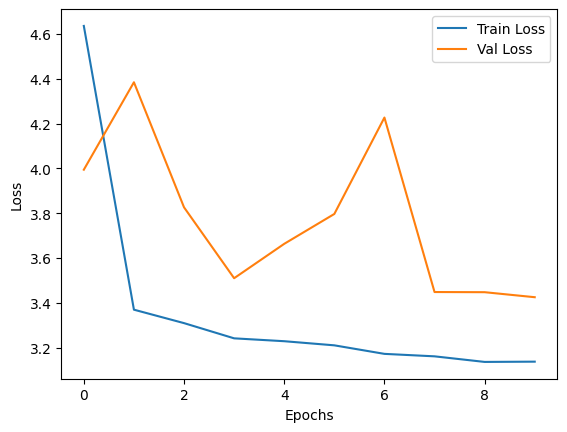

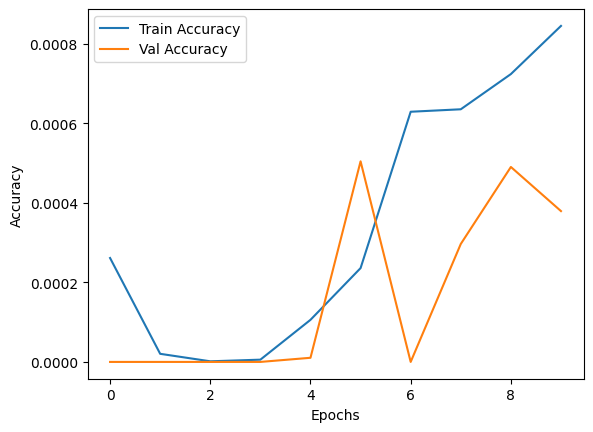

Training on cuda:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1/10 Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Epoch 1/10 Training: Accuracy: 0.0001, Loss: 3.5069
Epoch 1/10 Validation: Accuracy: 0.0000, Loss: 3.9025


Epoch 2/10 Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Epoch 2/10 Training: Accuracy: 0.0000, Loss: 3.0803
Epoch 2/10 Validation: Accuracy: 0.0000, Loss: 3.4714


Epoch 3/10 Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Epoch 3/10 Training: Accuracy: 0.0000, Loss: 3.0282
Epoch 3/10 Validation: Accuracy: 0.0000, Loss: 3.1171


Epoch 4/10 Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Epoch 4/10 Training: Accuracy: 0.0000, Loss: 3.0193
Epoch 4/10 Validation: Accuracy: 0.0000, Loss: 3.0520


Epoch 5/10 Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Epoch 5/10 Training: Accuracy: 0.0000, Loss: 3.0095
Epoch 5/10 Validation: Accuracy: 0.0000, Loss: 3.0668


Epoch 6/10 Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Epoch 6/10 Training: Accuracy: 0.0000, Loss: 2.9957
Epoch 6/10 Validation: Accuracy: 0.0000, Loss: 3.0760


Epoch 7/10 Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Epoch 7/10 Training: Accuracy: 0.0000, Loss: 2.9951
Epoch 7/10 Validation: Accuracy: 0.0000, Loss: 3.0594


Epoch 8/10 Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Epoch 8/10 Training: Accuracy: 0.0000, Loss: 2.9920
Epoch 8/10 Validation: Accuracy: 0.0000, Loss: 3.0507


Epoch 9/10 Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Epoch 9/10 Training: Accuracy: 0.0000, Loss: 2.9844
Epoch 9/10 Validation: Accuracy: 0.0000, Loss: 3.0494


Epoch 10/10 Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Epoch 10/10 Training: Accuracy: 0.0000, Loss: 2.9936
Epoch 10/10 Validation: Accuracy: 0.0000, Loss: 3.0472


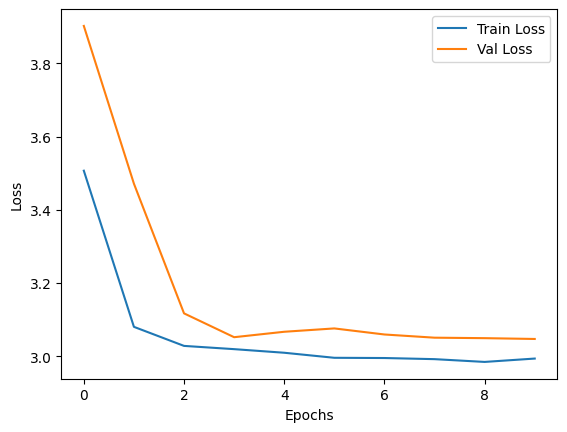

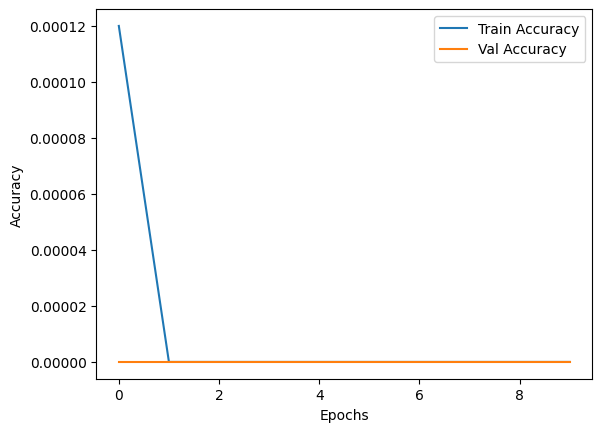

In [16]:
# initialize the model
LR = 0.001
Epochs = 10

net = CRNN(
    cnn_cfg = [ (2,64), "M", (3,128), "M", (3,256)],
    rnn_cfg = (256, 2),
    input_height = 1220,
    input_width = 1220,
    output_classes = text_transform.find_vocabulary_size(), 
    output_max_len = MAX_TEXT_LEN,
    dropout=0.2,
).to(compute_unit)



# Train the model
if TRAIN:
    optimizer = torch.optim.AdamW(net.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(TrainDataloader_General) * Epochs, eta_min=0.0001, last_epoch=-1)
    loss_func = nn.CTCLoss(blank=BLANK_SYMBOL, zero_infinity=False)
    
    _ = model_train(
        TrainDataloader_General, 
        ValDataloader_General, 
        net, 
        loss_func, 
        optimizer, 
        scheduler,
        epochs=Epochs, 
        compute_unit=compute_unit
    )
    
    optimizer = torch.optim.AdamW(net.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(TrainDataloader_Specific) * Epochs, eta_min=0.0001, last_epoch=-1)
    loss_func = nn.CTCLoss(blank=BLANK_SYMBOL, zero_infinity=False)
    
    _ = model_train(
        TrainDataloader_Specific, 
        ValDataloader_Specific, 
        net, 
        loss_func, 
        optimizer, 
        scheduler,
        epochs=Epochs, 
        compute_unit=compute_unit
    )

## Save the model

In [17]:
torch.save(net.state_dict(), "model.pt")

# Predict test data

### Load the trained model

In [18]:
net = CRNN(
    cnn_cfg = [ (2,64), "M", (3,128), "M", (3,256)],
    rnn_cfg = (256, 2),
    input_height = 1220,
    input_width = 1220,
    output_classes = text_transform.find_vocabulary_size(), 
    output_max_len = MAX_TEXT_LEN,
    dropout=0.2,
).to(compute_unit)

net.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [19]:
test_images = convert_from_path(SPECIFIC_DATASET + 'Padilla - Nobleza virtuosa_testExtract.pdf')
    
for index,image in enumerate(test_images):
    test_images[index] = Image.fromarray(np.asarray(image))
    
test_images = crop_images(test_images)
    
# image resizing
test_images = resize_images(test_images, 1220, 1220)

# grey convertion
test_images = grey_convertion(test_images)

test_images = np.asarray(test_images)

# normalize the images
test_images = normalization(test_images)

Test_Tensor = torch.stack([transforms.ToTensor()(x) for x in test_images])[-6:]

In [32]:
print(text_transform.int_to_char)
print(text_transform.int_to_char[82])

{0: '', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: 'A', 28: 'B', 29: 'C', 30: 'D', 31: 'E', 32: 'F', 33: 'G', 34: 'H', 35: 'I', 36: 'J', 37: 'K', 38: 'L', 39: 'M', 40: 'N', 41: 'O', 42: 'P', 43: 'Q', 44: 'R', 45: 'S', 46: 'T', 47: 'U', 48: 'V', 49: 'W', 50: 'X', 51: 'Y', 52: 'Z', 53: 'ñ', 54: 'Ñ', 55: '0', 56: '1', 57: '2', 58: '3', 59: '4', 60: '5', 61: '6', 62: '7', 63: '8', 64: '9', 65: '.', 66: ',', 67: ';', 68: ':', 69: '!', 70: '?', 71: '¿', 72: '¡', 73: 'NEWLINE', 74: 'SPACE', 75: "'", 76: '"', 77: '-', 78: '_', 79: '(', 80: ')', 81: '<', 82: '>', 83: '|'}
>


In [37]:
net.eval()


predictionsprob = net(Test_Tensor.to(compute_unit)).cpu()
pred = torch.argmax(predictionsprob, dim=2)

results = []
for i in range(pred.shape[0]):
    results.append(text_transform.int_to_text(pred[i].cpu().numpy()))
    
# Save the results to a file
final = pd.DataFrame(results, columns=["Text"]) 

final.to_csv("results.csv", index=False)